In [1]:
%load_ext lab_black

In [2]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf
import wandb
import xarray as xr
from dataclasses import dataclass, field
from hydra import compose, initialize
from hydra.utils import call, instantiate
from icecream import ic
from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf
from sklearn import preprocessing
from tensorflow import keras
from typing import List, Optional
from wandb.keras import WandbCallback, WandbMetricsLogger
from model_eval import *
import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import model_eval
import models.reg as rm
from Data import Data_eval, Data_train
from include.callbacks import ExtraValidation, get_modelcheckpoint, initiate_wb
from model_training import Model_training_manager, Trainer
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer
from saver import Saver
import hydra
from omegaconf import OmegaConf
import data.utils as data_utils


setMatplotlibParam()
plt.viridis()

2024-01-08 12:27:54.074619: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 12:27:54.111443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 12:27:54.111472: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 12:27:54.111493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 12:27:54.118243: I tensorflow/core/platform/cpu_feature_g

<Figure size 1920x1440 with 0 Axes>

### Model

In [3]:
dir_res = "/libre/dumontj/coco2/weights"
name_model = os.path.join(dir_res, "new/inv_lip_clouds_sweep_save/4")
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [4]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2024-01-08 12:27:59.418115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model_16 (Functional)       (None, 576)               185984    
                                                                 
 dense_4 (Dense)             (None, 1)                 577       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 186561 (728.75 KB)
Trainable params: 186369 (728.00 KB)
Non-trainable params: 192 (768.00 Byte)
_________________________________________________________________


### Generator

In [6]:
cfg = OmegaConf.load(os.path.join(name_model, "config.yaml"))

In [12]:
cfg

{'data': {'init': {'_target_': 'Data.Data_train', 'path_train_ds': '${data.path.directory}/${data.path.train.name}/${data.path.train.nc}', 'path_valid_ds': '${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}', 'path_extra_valid_ds': '${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}'}, 'input': {'dir_seg_models': '/cerea_raid/users/dumontj/dev/coco2/dl/res/models', 'chan_0': 'xco2', 'chan_1': 'v_wind', 'chan_2': 'u_wind', 'chan_3': 'no2', 'chan_4': 'None', 'cloud_bool': True, 'path_clouds_array': '/libre/dumontj/coco2/dl-input/clouds/extracted_clouds.npy'}, 'output': {'N_emissions': 1}, 'path': {'directory': '/libre/dumontj/coco2/dl-input', 'train': {'name': '2km_forLip_2', 'nc': 'train_dataset.nc'}, 'valid': {'name': '2km_forLip_2', 'nc': 'valid_dataset.nc'}, 'extra_valid': {'name': '2km_Lip', 'nc': 'valid_dataset.nc'}}}, 'dir_res': '/libre/dumontj/coco2/weights/new/', 'exp_name': 'inv_lip', 'seed': 42, 'sweep': True, 'model': {'type': 

In [14]:
data = instantiate(cfg.data.init)
data.prepare_input(
    cfg.data.input.chan_0,
    cfg.data.input.chan_1,
    cfg.data.input.chan_2,
    cfg.data.input.chan_3,
    cfg.data.input.chan_4,
    cfg.data.input.cloud_bool,
    cfg.data.input.path_clouds_array,
    cfg.data.input.dir_seg_models,
)
data.prepare_output_inversion(cfg.data.output.N_emissions)

ic| self.train.shape: (25152, 64, 64, 4)


In [15]:
generator = generators.InvDataGen(
    data.x.train,
    data.x.plumes_train,
    data.x.xco2_back_train,
    data.x.xco2_alt_anthro_train,
    data.y.train,
    data.x.scale_bool,
    data.x.fields_input_shape,
    data.x.clouds_training,
    data.x.noise_layer,
    data.x.norm_layer,
    data.x.cloud_layer,
    plume_scaling_min=cfg.augmentations.plume_scaling_min,
    plume_scaling_max=cfg.augmentations.plume_scaling_max,
)

In [16]:
num_samples = 1000
collected_samples = []
collected_outputs = []
collected_count = 0

for batch in generator:
    batch_size = batch[0].shape[0]
    collected_count += batch_size
    collected_samples.append(batch[0])
    collected_outputs.append(batch[1])
    if collected_count >= num_samples:
        break

collected_samples = np.concatenate(collected_samples, axis=0)[:num_samples]
collected_outputs = np.concatenate(collected_outputs, axis=0)[:num_samples]

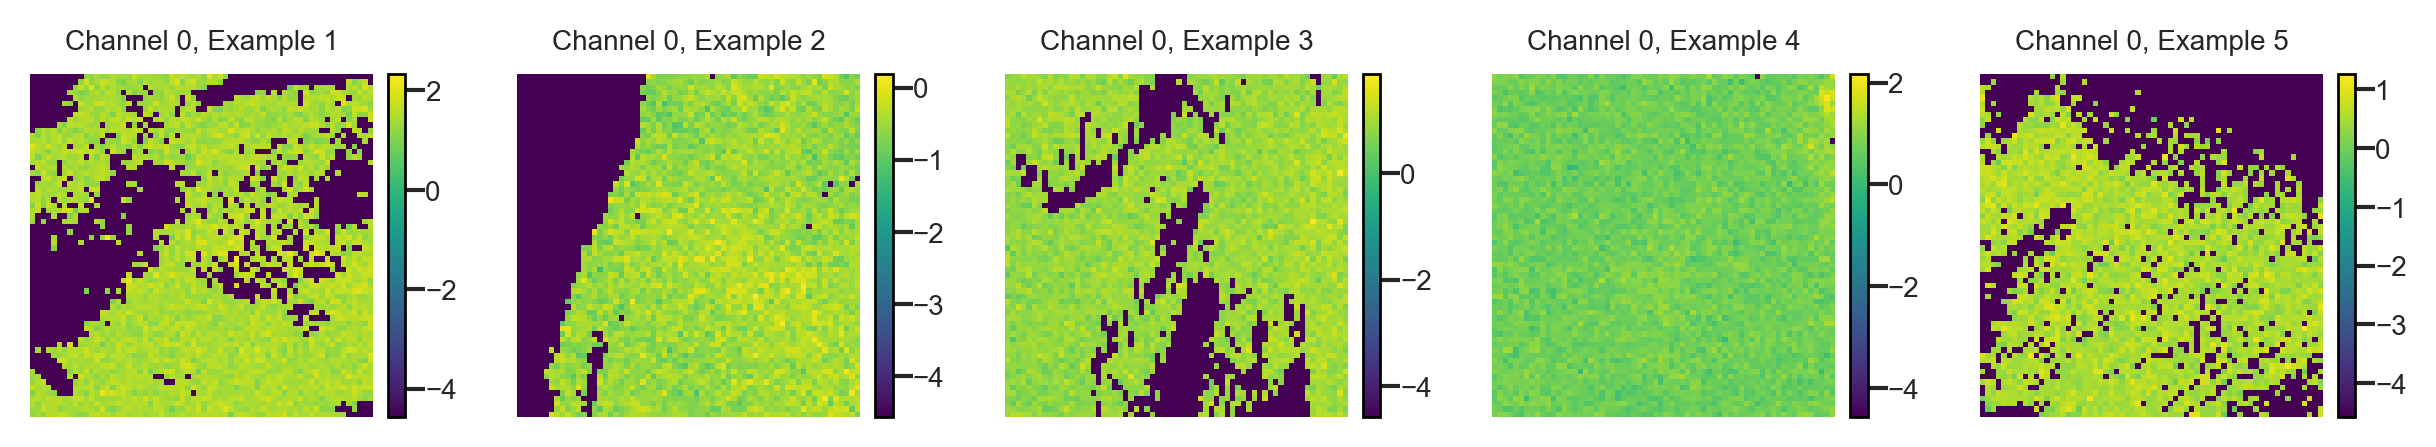

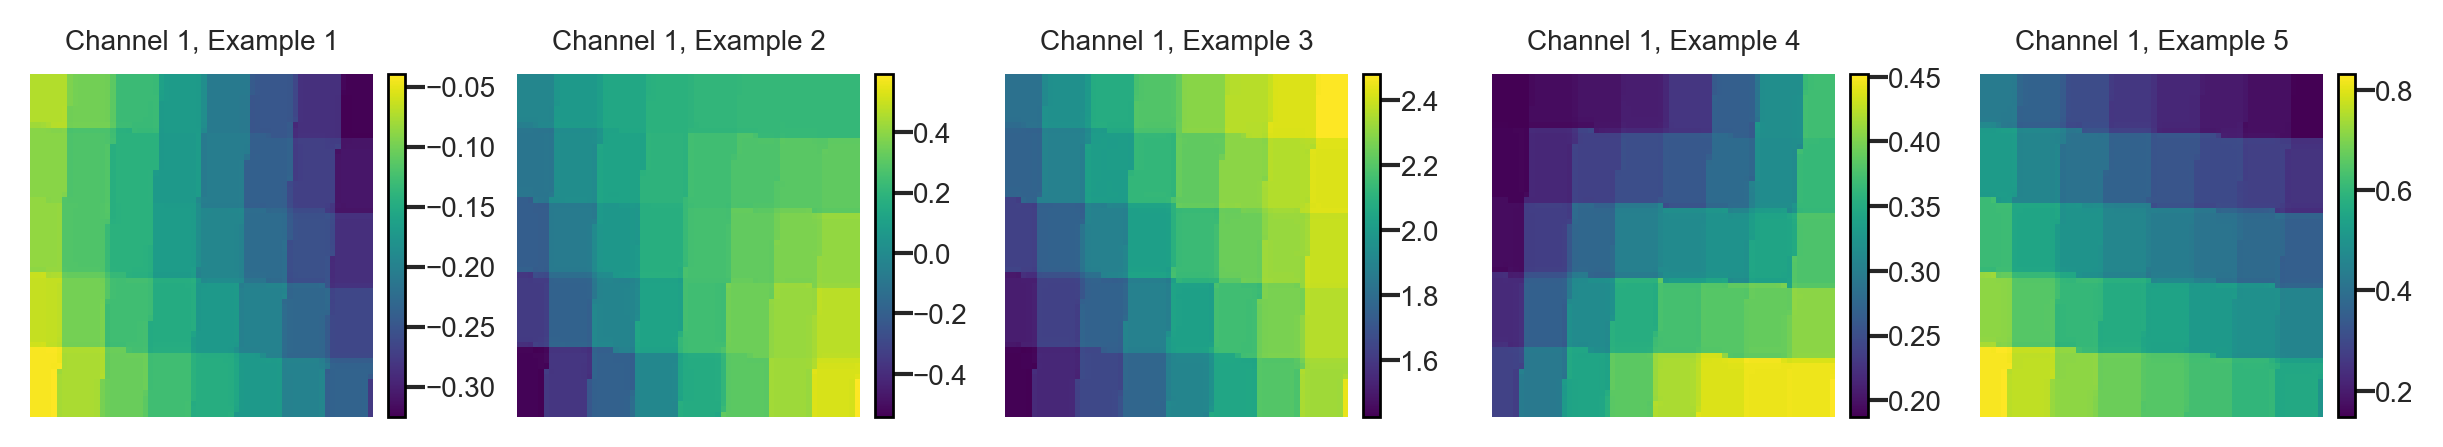

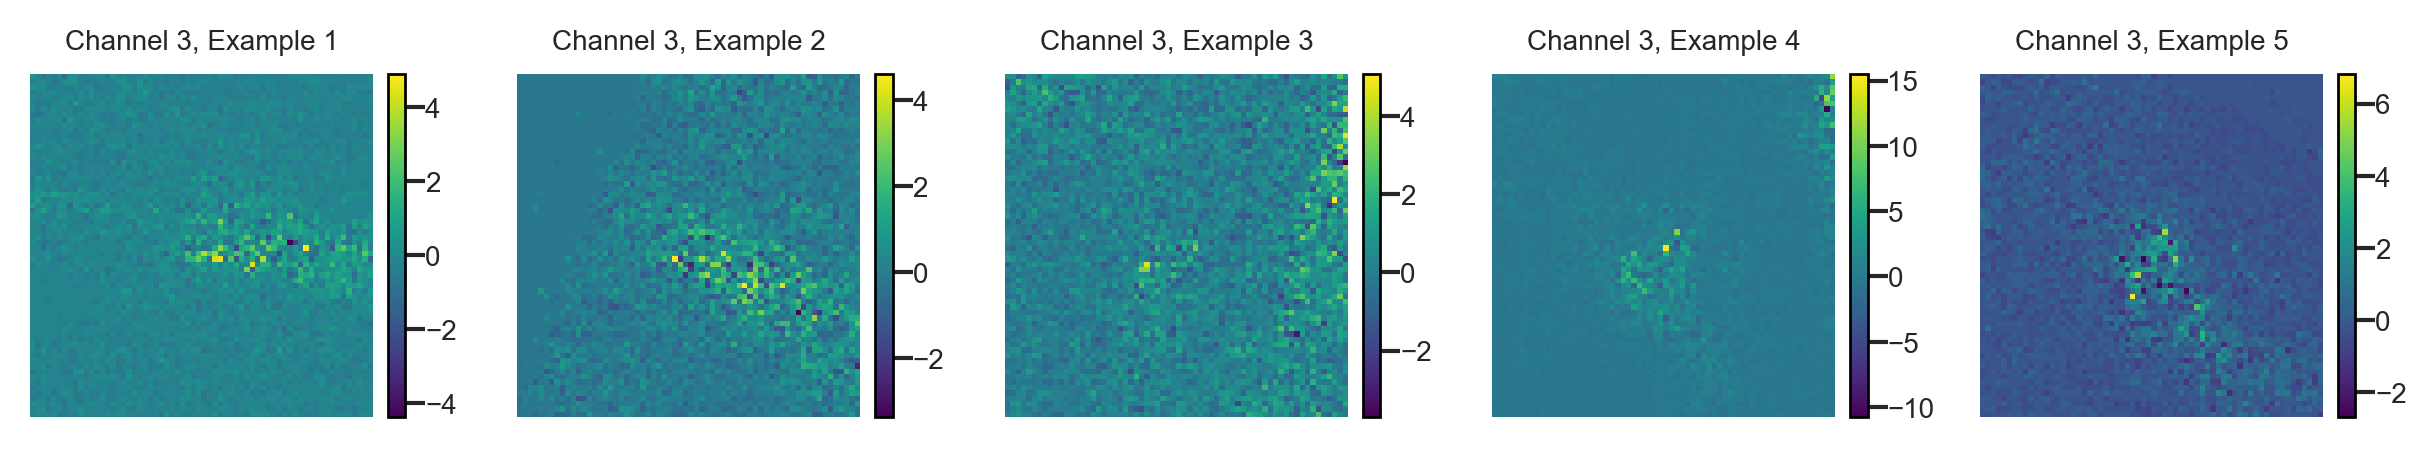

In [17]:
num_examples = 5
plot_data = collected_samples
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

# Classic eval

### Train data

In [6]:
data_train = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_train_nc
)

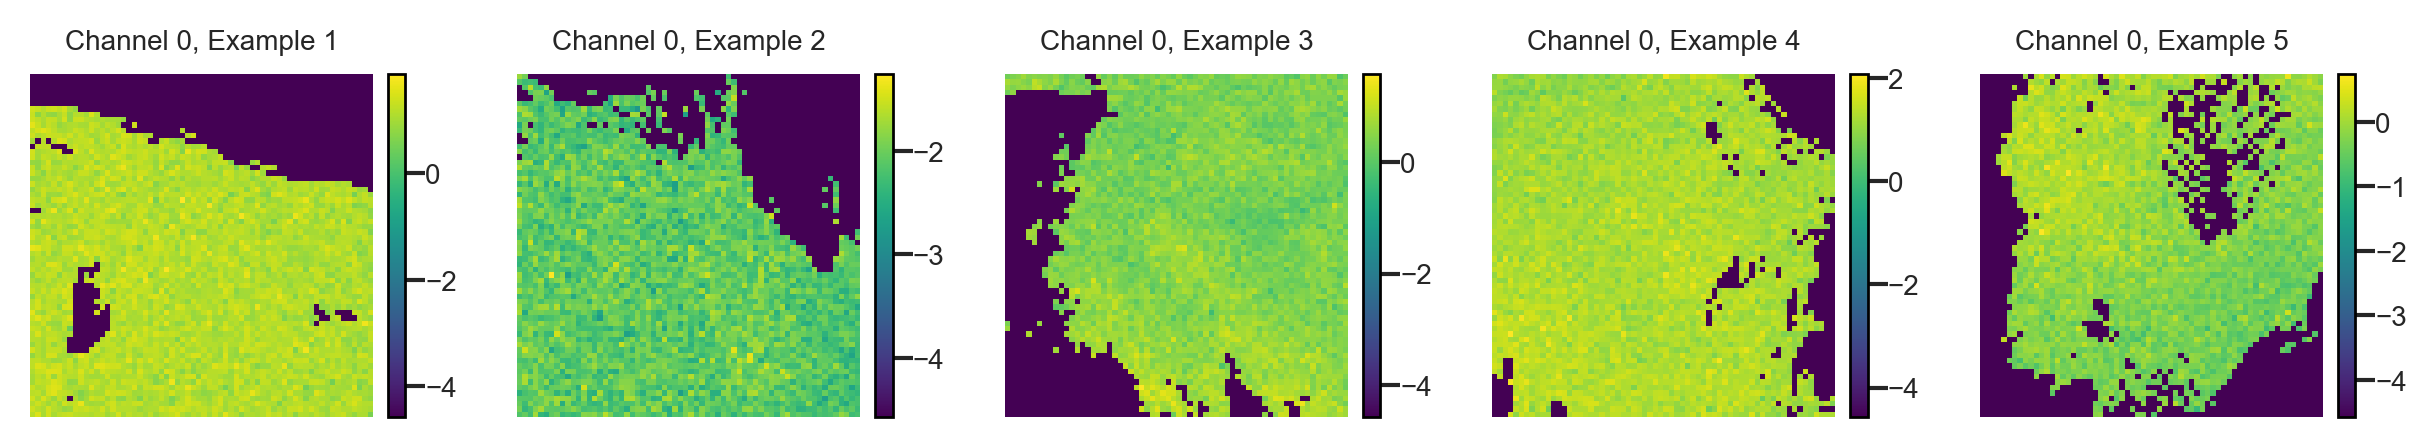

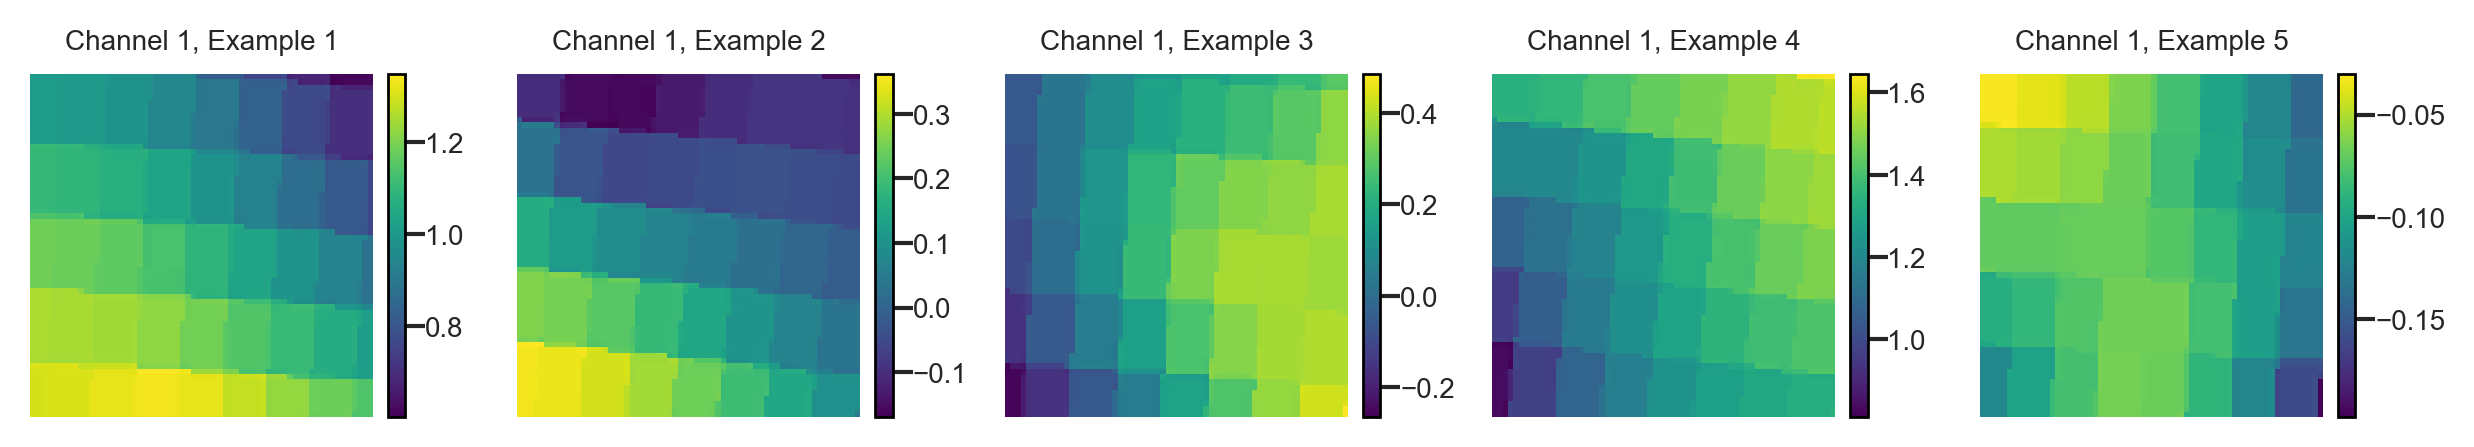

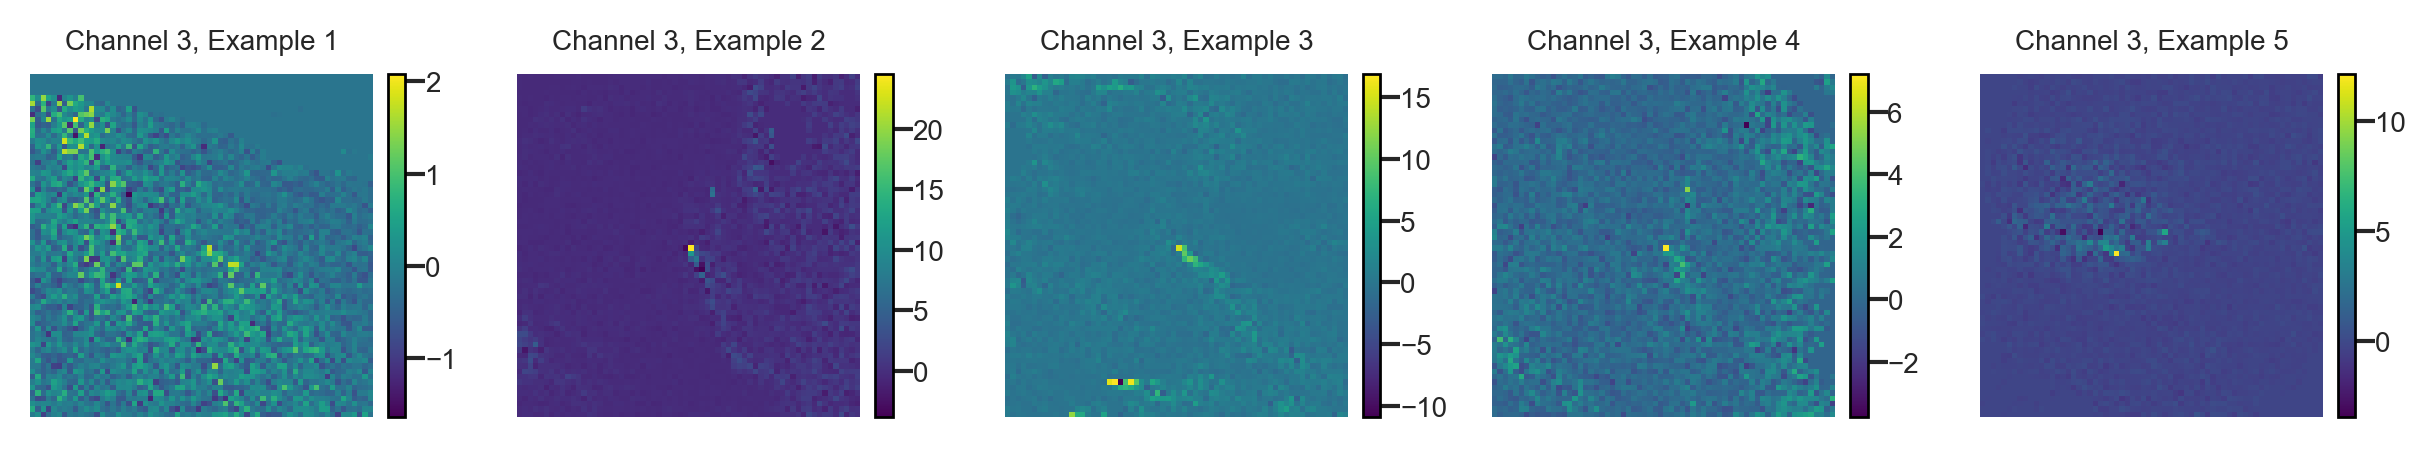

In [7]:
num_examples = 5
plot_data = data_train.x.eval
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [9]:
eval_on_train = model_eval.InversionModelEvaluation(model=model, data=data_train)
metrics = eval_on_train.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

786/786 [==============================] - 7s 9ms/step
mae: 2.8823183
mape: 26.047325


### Valid data

In [6]:
data_valid = get_data_for_inversion(os.path.join(dir_res, name_model), path_valid_nc)

ic| self.eval.shape: (4608, 64, 64, 3)


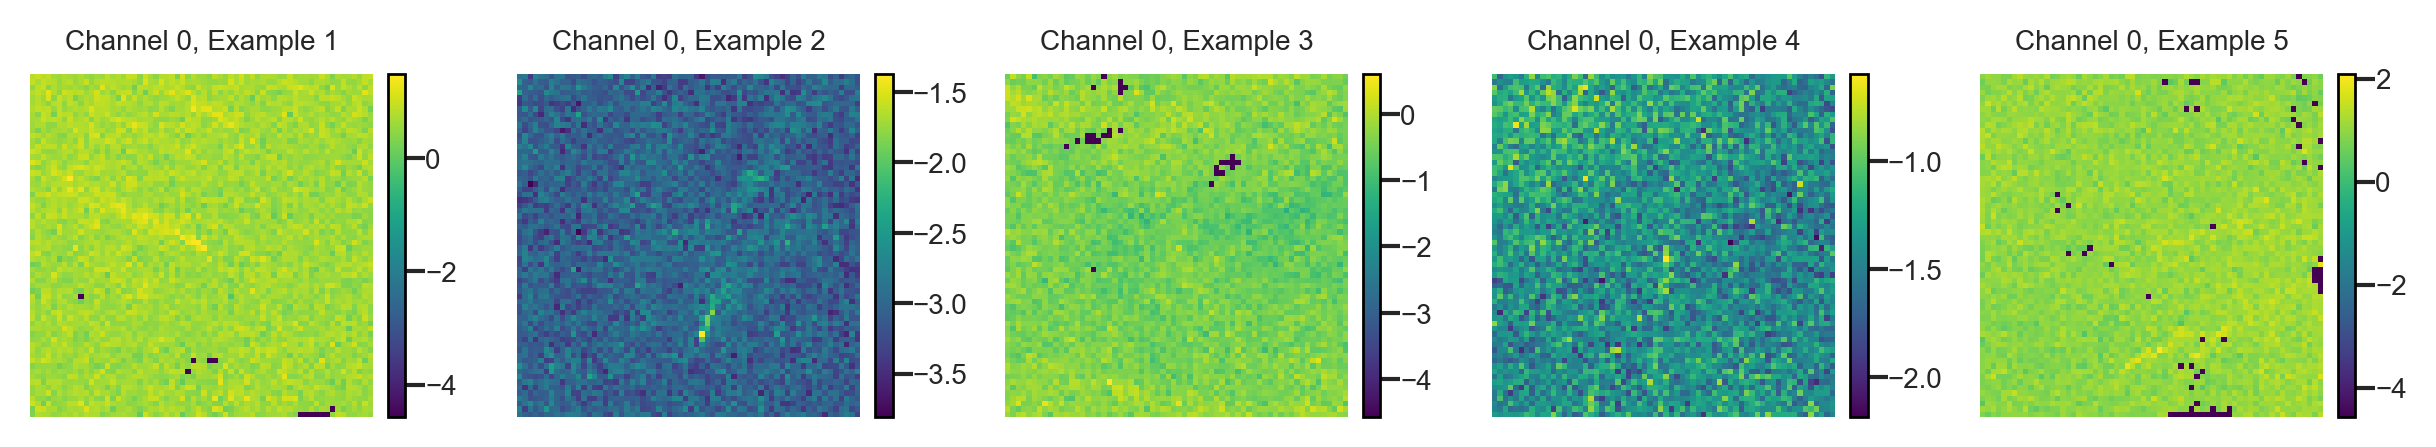

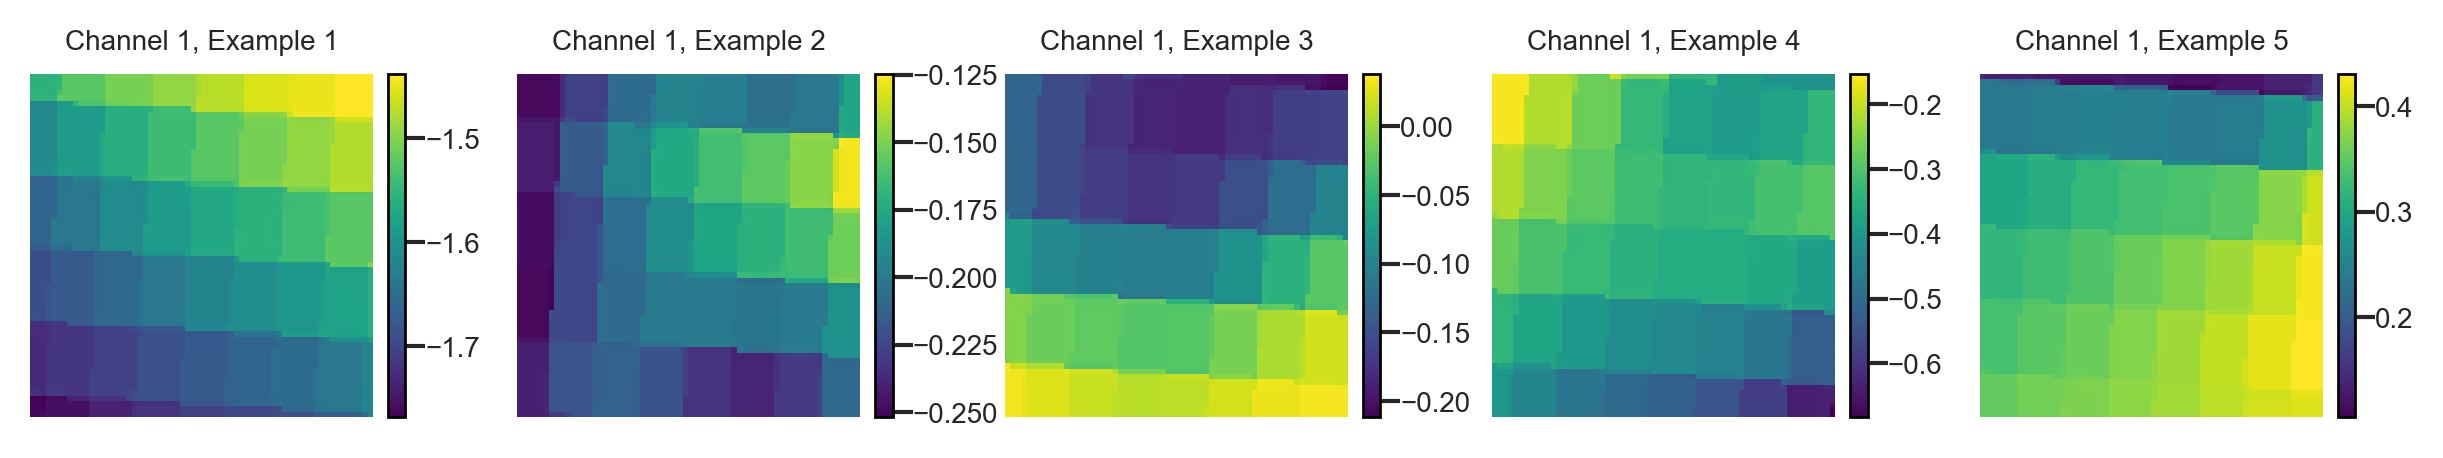

In [7]:
num_examples = 5
plot_data = data_valid.x.eval
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [8]:
eval_on_valid = model_eval.InversionModelEvaluation(model=model, data=data_valid)
metrics = eval_on_valid.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 2s 10ms/step
mae: 3.5188456
mape: 28.706564


### Extra_valid data

In [6]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_extra_valid_nc
)

ic| self.eval.shape: (1152, 64, 64, 3)


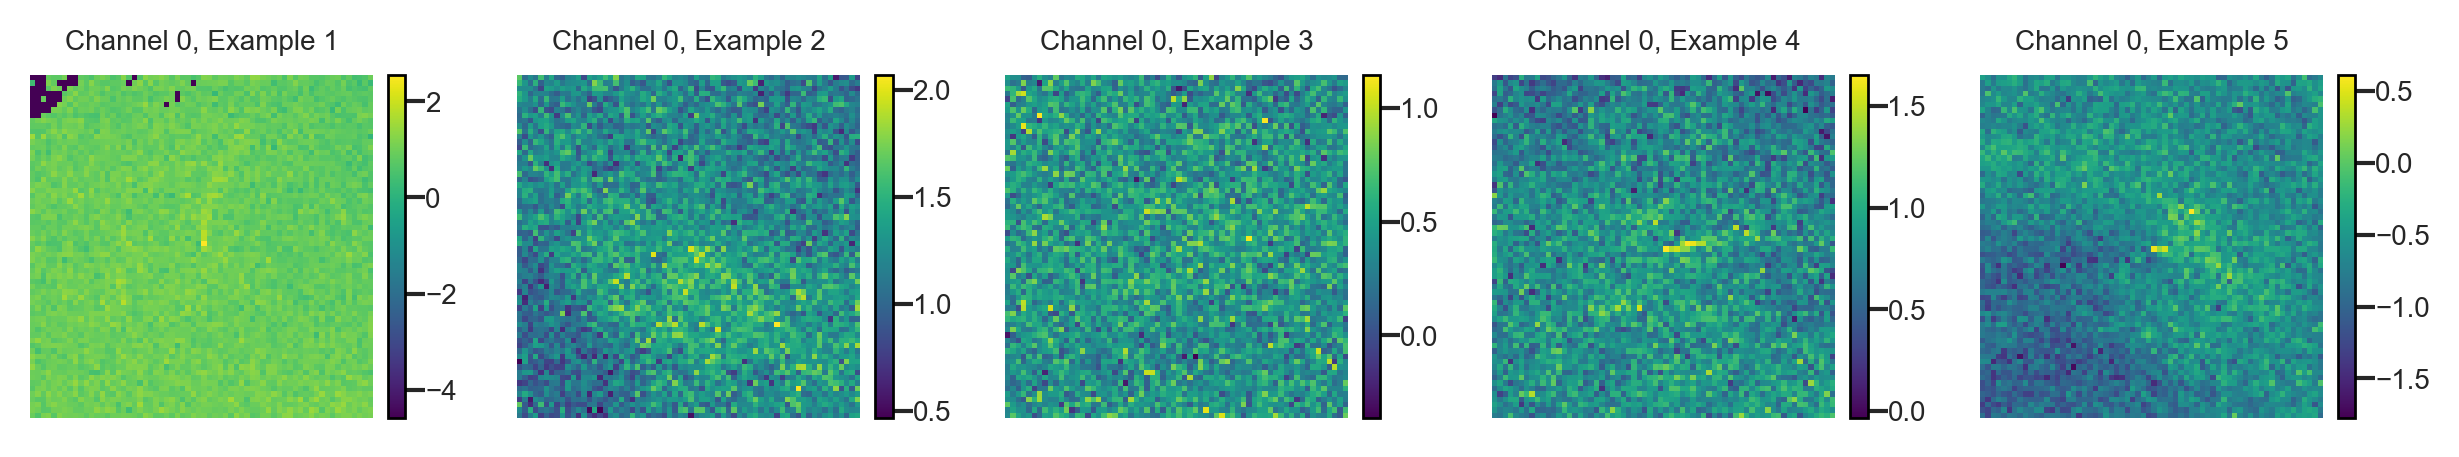

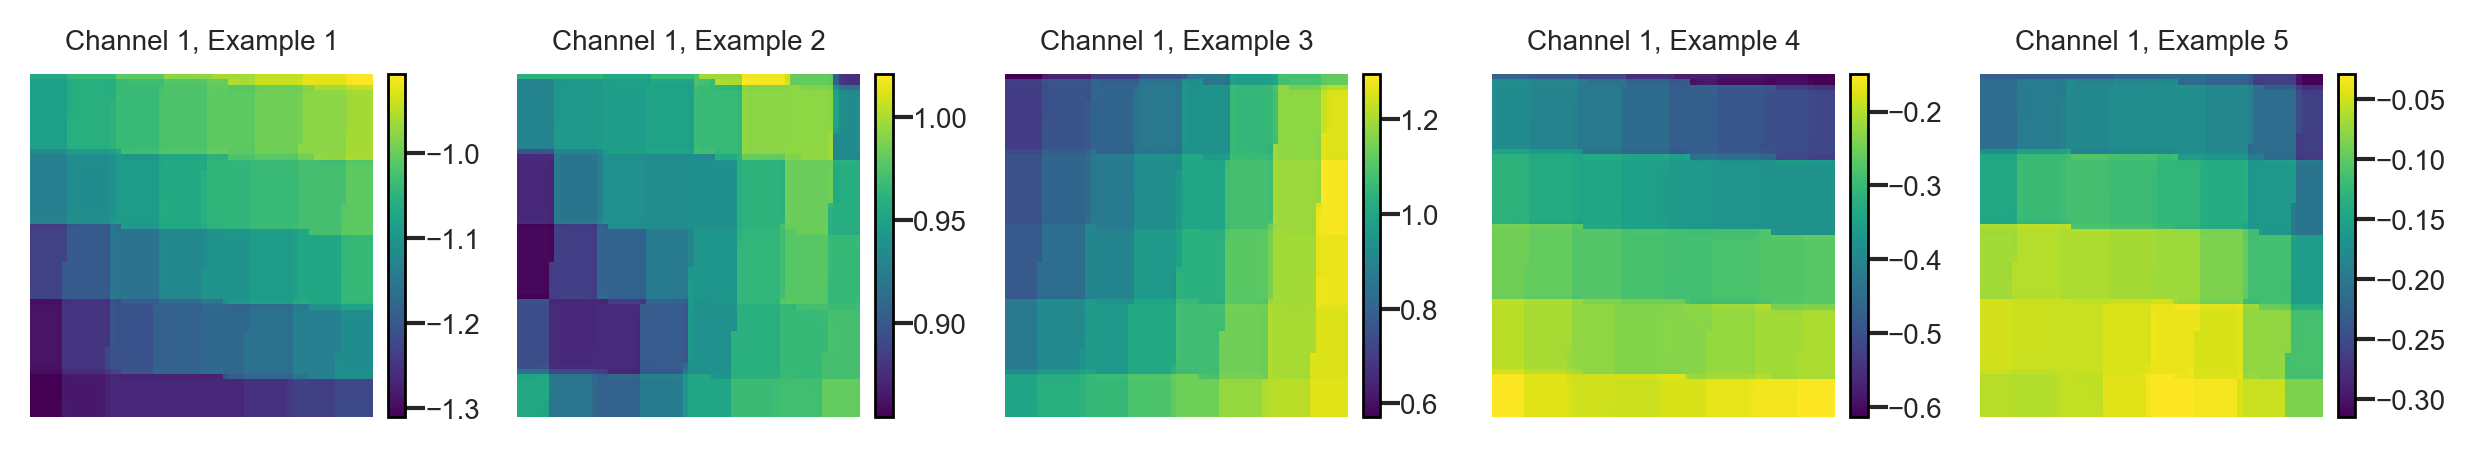

In [7]:
num_examples = 5
plot_data = data.x.eval
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

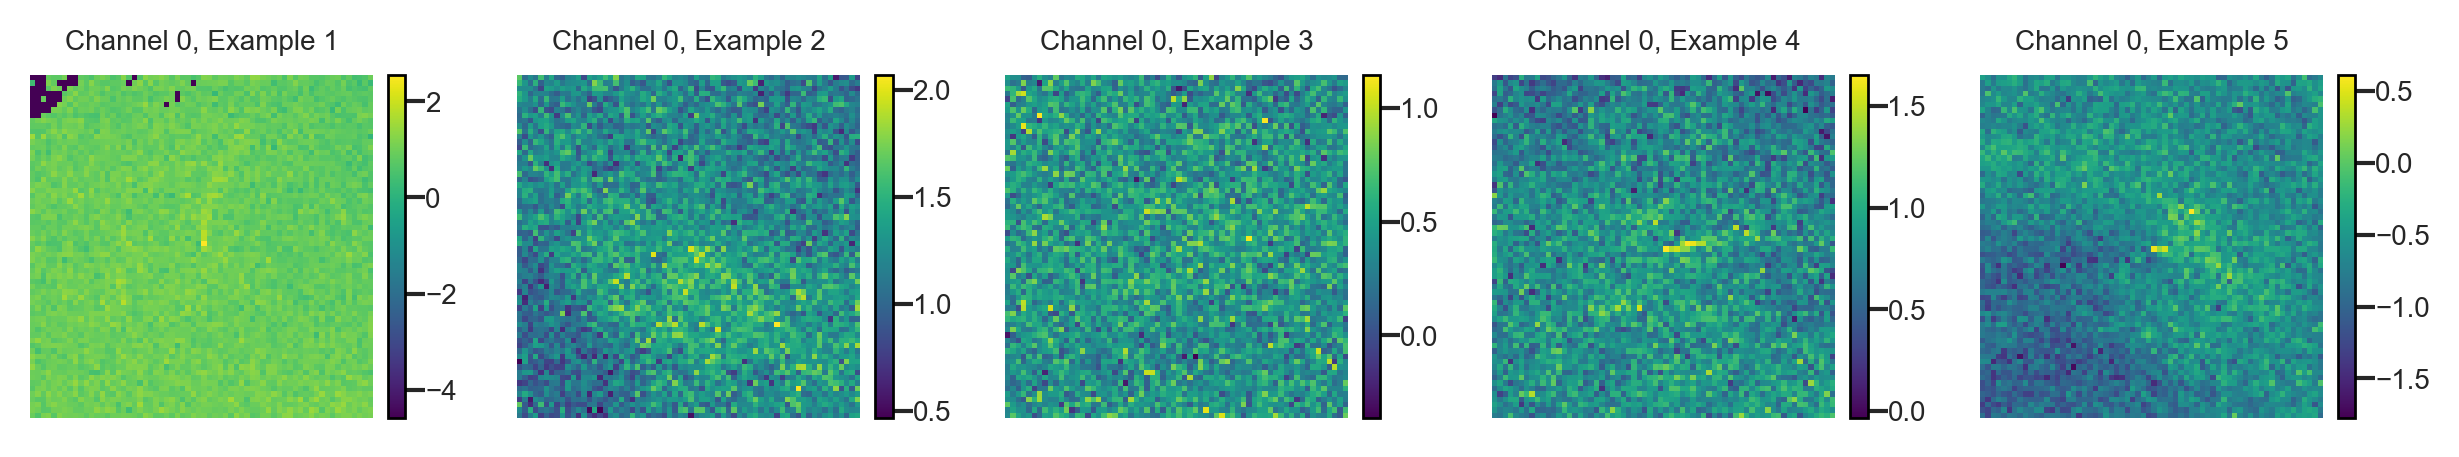

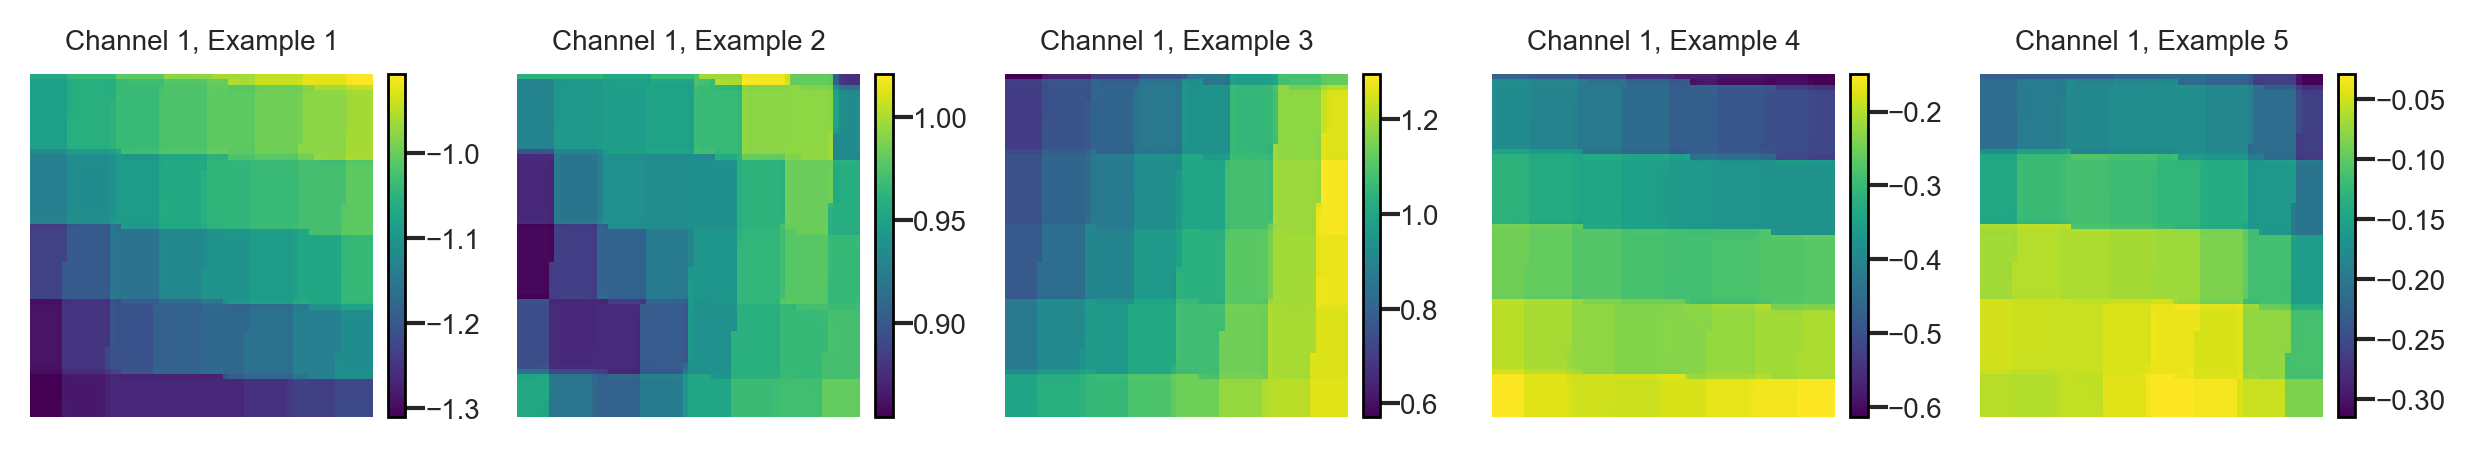

In [8]:
for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

In [7]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 1s 10ms/step
mae: 3.9679947
mape: 25.655823


## Plots / Study

### General 

144/144 [==============================] - 1s 8ms/step


<Figure size 1920x1440 with 0 Axes>

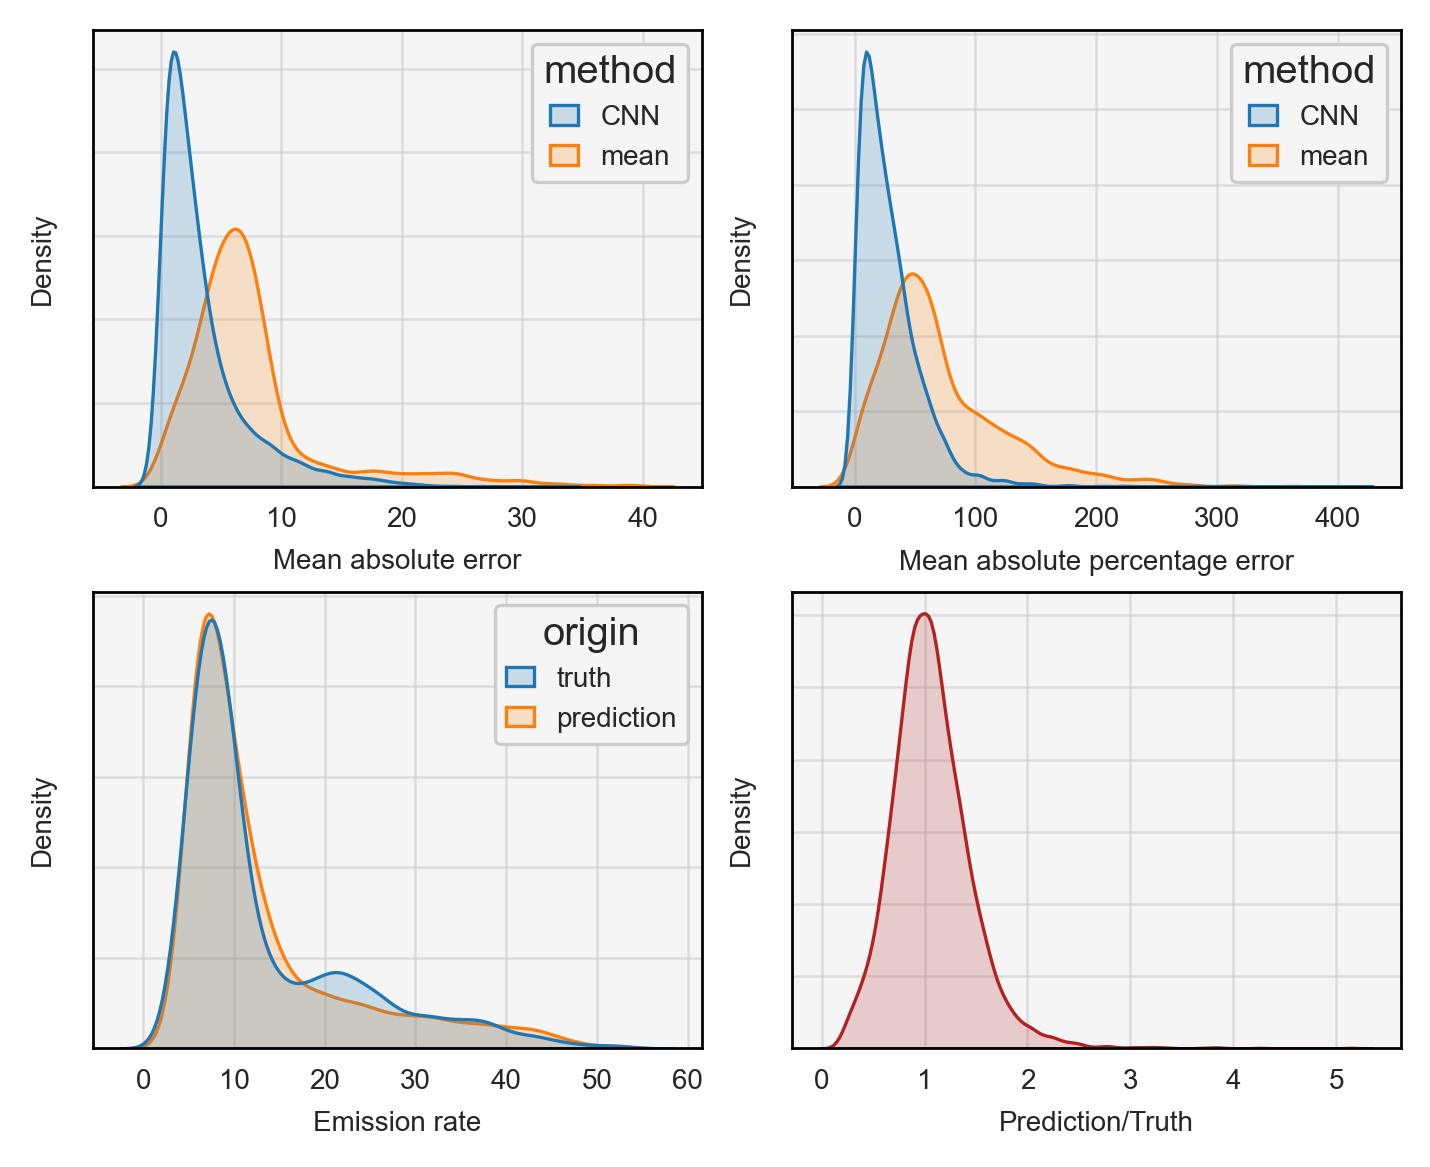

In [13]:
model_eval.get_summary_histo_inversion(model, data_valid)

36/36 [==============================] - 0s 9ms/step


<Figure size 1920x1440 with 0 Axes>

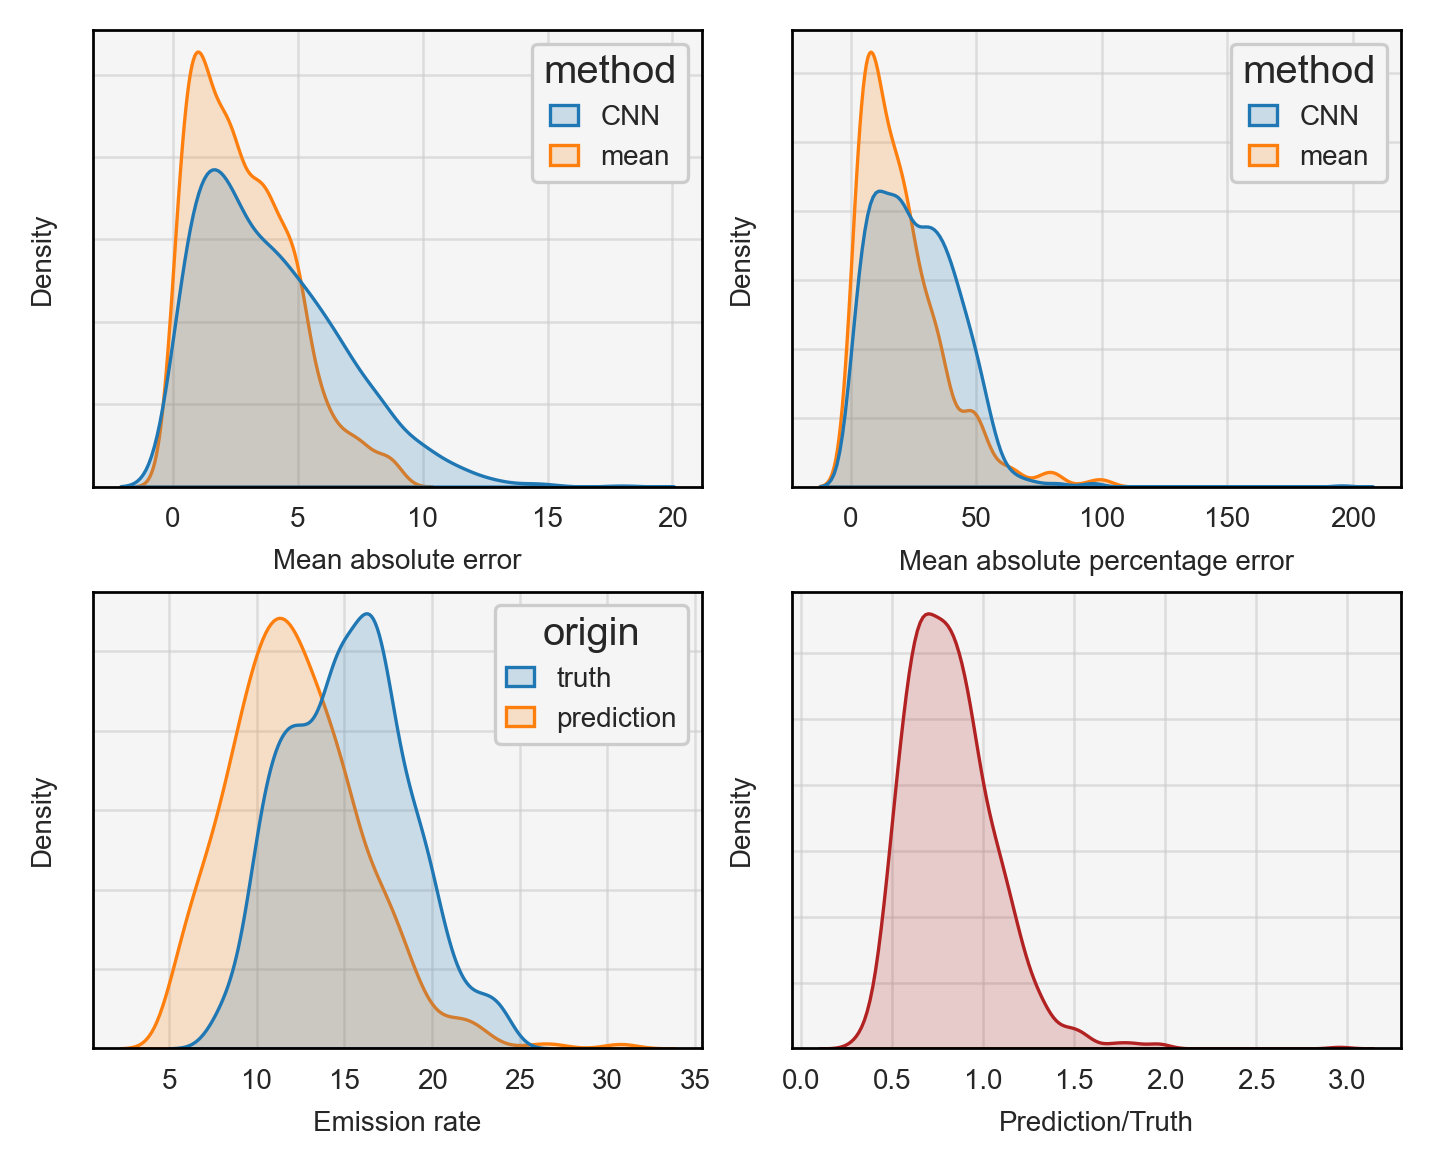

In [14]:
model_eval.get_summary_histo_inversion(model, data)

nwbce: 3.276498794555664
idx: 268
origin: smart_2km_Lip_64
time: 2015-03-22T04:00:00.000000000
emiss: [ 9.525166  9.267331 10.16818 ]

nwbce: 1.5203990936279297
idx: 760
origin: smart_2km_Lip_64
time: 2015-08-22T16:00:00.000000000
emiss: [13.20888 13.68982 14.04938]

nwbce: 0.11283111572265625
idx: 525
origin: smart_2km_Lip_64
time: 2015-06-07T21:00:00.000000000
emiss: [10.70874 10.81517 11.34591]

nwbce: 2.7528762817382812
idx: 546
origin: smart_2km_Lip_64
time: 2015-06-21T18:00:00.000000000
emiss: [11.0274  11.66457 12.08935]



<Figure size 1920x1440 with 0 Axes>

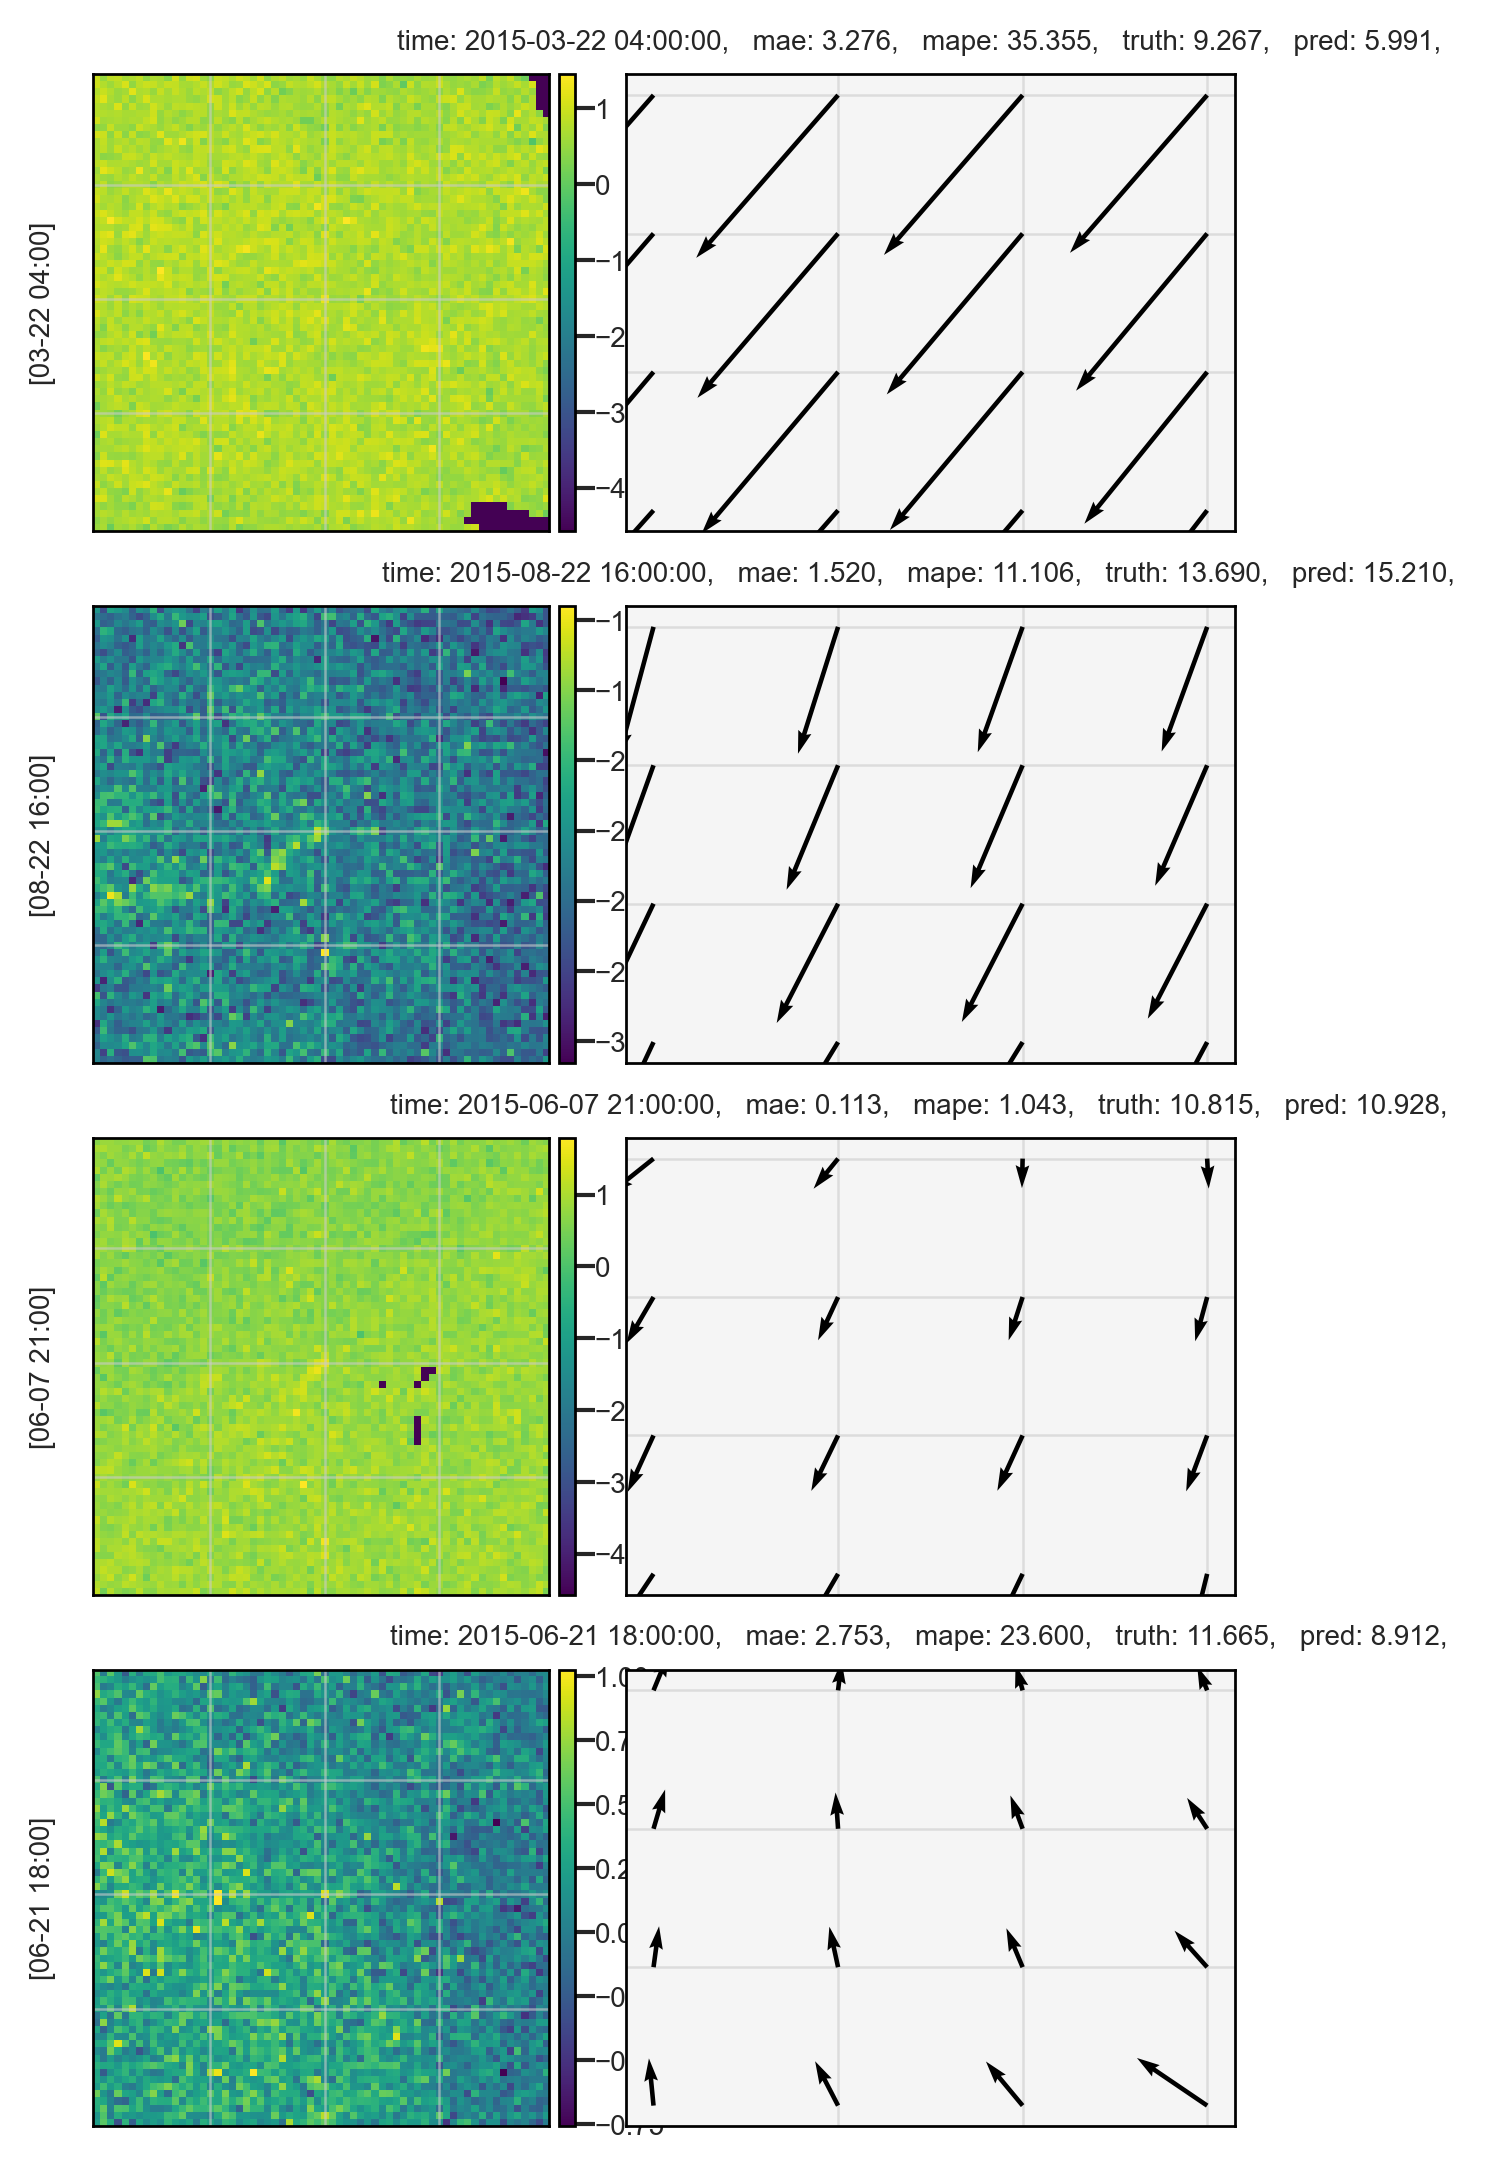

In [15]:
inv_plotter = InversionPlotter(inv_eval)
inv_plotter.plot_examples()

### Worst results

In [26]:
def count_and_get_images_in_quantile_range(metrics, lower_quantile, upper_quantile):
    lower_bound = np.quantile(metrics, lower_quantile)
    upper_bound = np.quantile(metrics, upper_quantile)
    filtered_metrics = metrics[(metrics >= lower_bound) & (metrics <= upper_bound)]
    count = len(filtered_metrics)
    return count, filtered_metrics


count, values = count_and_get_images_in_quantile_range(metrics["mae"], 0.95, 1)
print("Count:", count)
print("Values:", values)

Count: 58
Values: tf.Tensor(
[ 9.344093  11.511244  11.611842  13.079176  11.591475   9.933296
 13.02737    9.432115   9.904845   9.278046   9.409943  10.463703
 12.278706  24.909678  11.478804  11.556176  14.302861  16.11026
 10.919685  10.29909   14.106976  10.675337  15.551119  12.299046
 11.279671   9.346998  11.828272   9.472216  10.2530985 19.991152
 23.48315   12.403697  16.106033   9.346392  11.137142  10.404491
  9.344446  11.950222  15.323556  10.157289  10.864965  26.744831
 11.943478  13.264933   9.978698  11.102101  13.8288145 10.604065
 11.204771   9.735088  10.944777  12.652313  11.606297   9.351395
  9.893246   9.426098   9.553505  42.94817  ], shape=(58,), dtype=float32)


nwbce: 10.463703155517578
idx: 97
origin: smart_2km_Lip_64
time: 2015-02-06T01:00:00.000000000
emiss: [14.04302 17.16355 19.69992]

nwbce: 9.933296203613281
idx: 42
origin: smart_2km_Lip_64
time: 2015-01-07T18:00:00.000000000
emiss: [20.55495 21.74158 22.53152]

nwbce: 9.432114601135254
idx: 47
origin: smart_2km_Lip_64
time: 2015-01-07T23:00:00.000000000
emiss: [17.39116 19.96109 20.15922]

nwbce: 9.34699821472168
idx: 251
origin: smart_2km_Lip_64
time: 2015-03-21T11:00:00.000000000
emiss: [17.19866 17.34093 15.35223]

nwbce: 10.919685363769531
idx: 174
origin: smart_2km_Lip_64
time: 2015-02-22T06:00:00.000000000
emiss: [13.68192 11.00301 10.70522]

nwbce: 9.933296203613281
idx: 42
origin: smart_2km_Lip_64
time: 2015-01-07T18:00:00.000000000
emiss: [20.55495 21.74158 22.53152]

nwbce: 13.07917594909668
idx: 35
origin: smart_2km_Lip_64
time: 2015-01-07T11:00:00.000000000
emiss: [23.91462 24.11241 21.3466 ]

nwbce: 19.991151809692383
idx: 262
origin: smart_2km_Lip_64
time: 2015-03-21T22:

<Figure size 1920x1440 with 0 Axes>

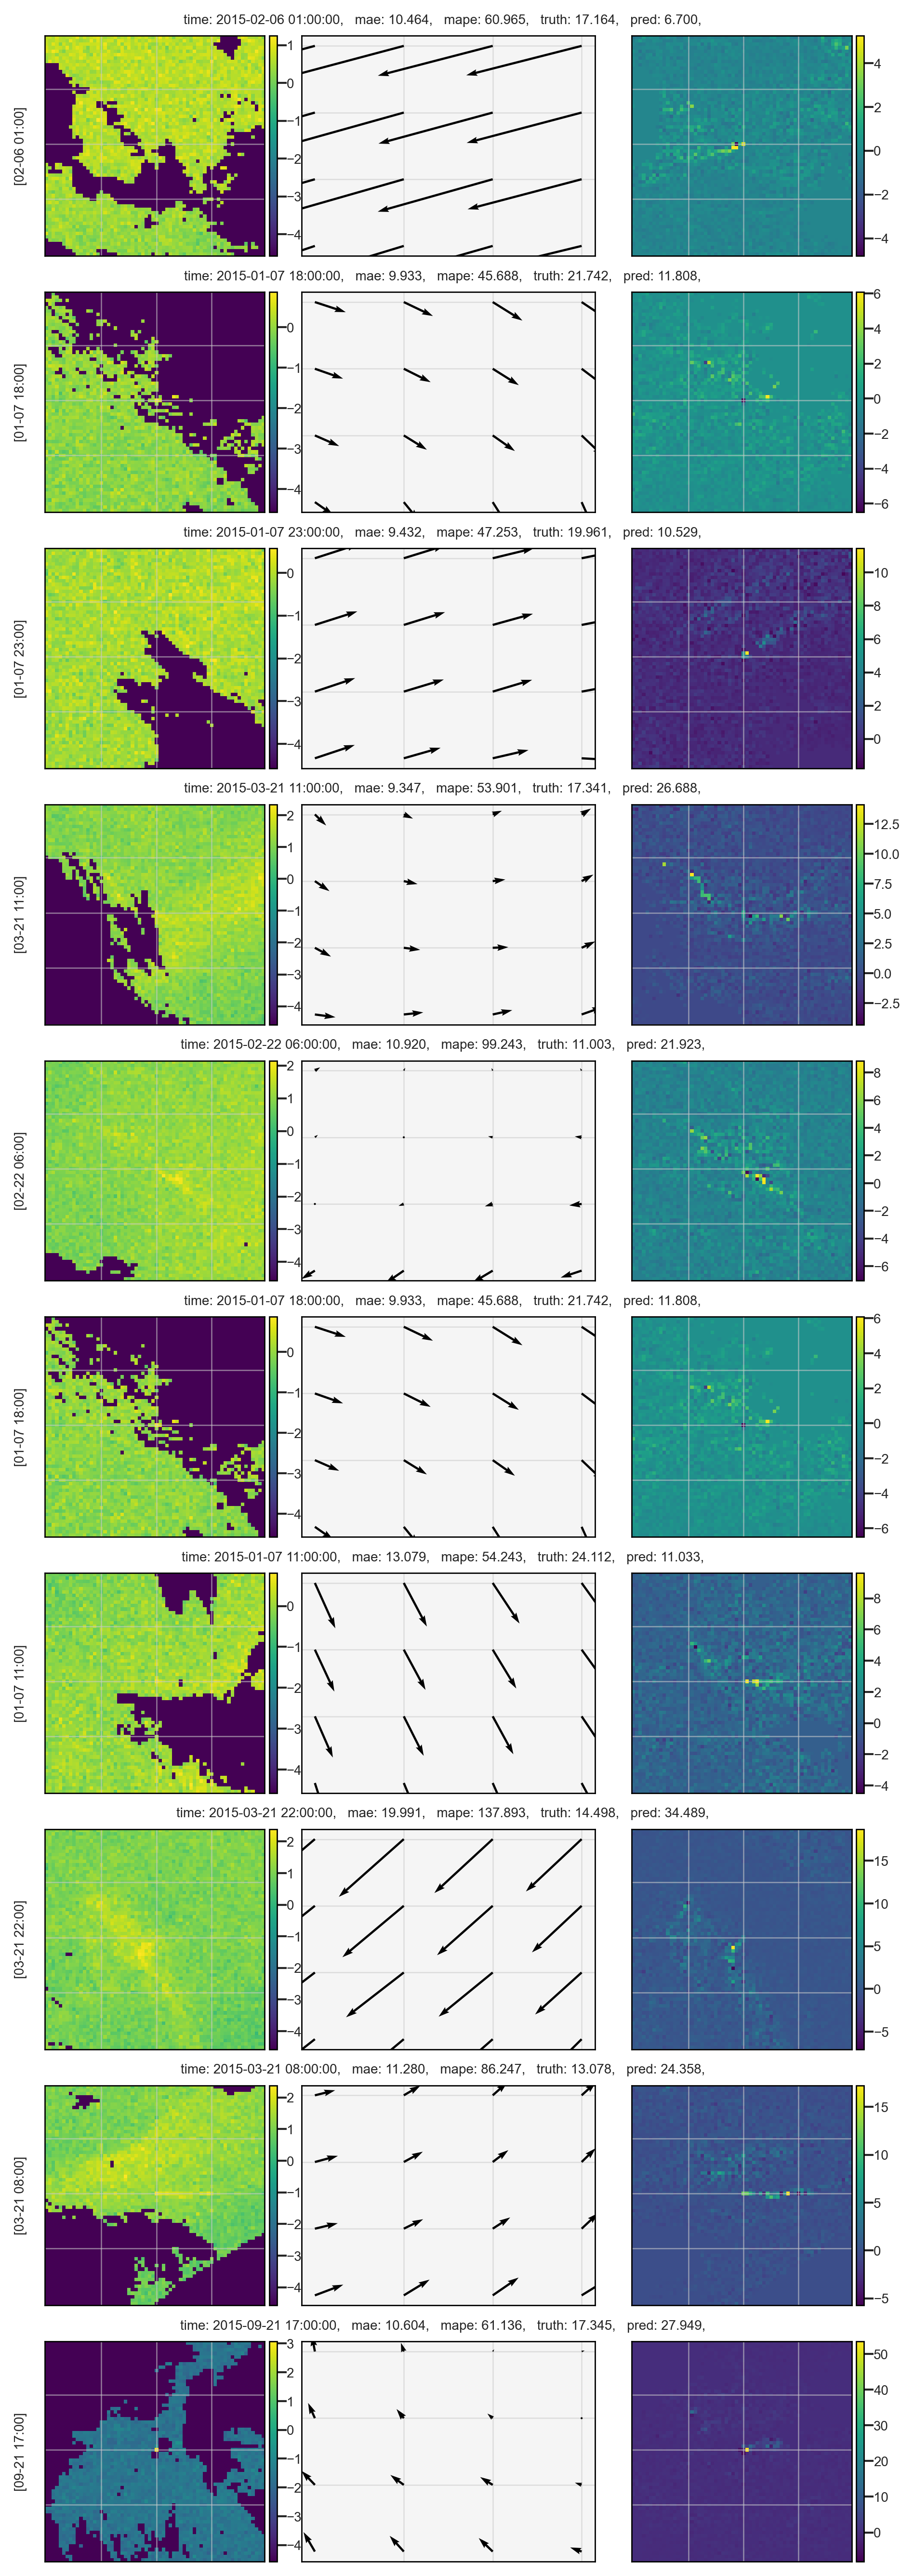

In [25]:
inv_plotter.N_rows = 10
inv_plotter.plot_examples(interval=[0.95, 1])

### About clouds

In [36]:
def count_clouds_pixels_in_centered_square(xco2_field, N=6):
    height, width = xco2_field.shape[1:3]
    center_y, center_x = height // 2, width // 2
    half_N = N // 2

    # Calculate the start and end indices for the square
    start_y, end_y = max(center_y - half_N, 0), min(center_y + half_N, height)
    start_x, end_x = max(center_x - half_N, 0), min(center_x + half_N, width)

    # Extract the centered square
    centered_square = xco2_field[:, start_y:end_y, start_x:end_x]

    # Count cloud pixels
    min_values = np.min(centered_square, axis=(1, 2))
    N_cloud_pixels = np.sum(centered_square == min_values[:, None, None], axis=(1, 2))

    return np.array(N_cloud_pixels)

In [37]:
N_cloud_pixels = count_clouds_pixels_in_centered_square(data.x.eval[:, :, :, 0])

In [38]:
correlation_coefficient = np.corrcoef(N_cloud_pixels, metrics["mape"])[0, 1]
ic(correlation_coefficient)

ic| correlation_coefficient: 0.0031817383358571697


0.0031817383358571697

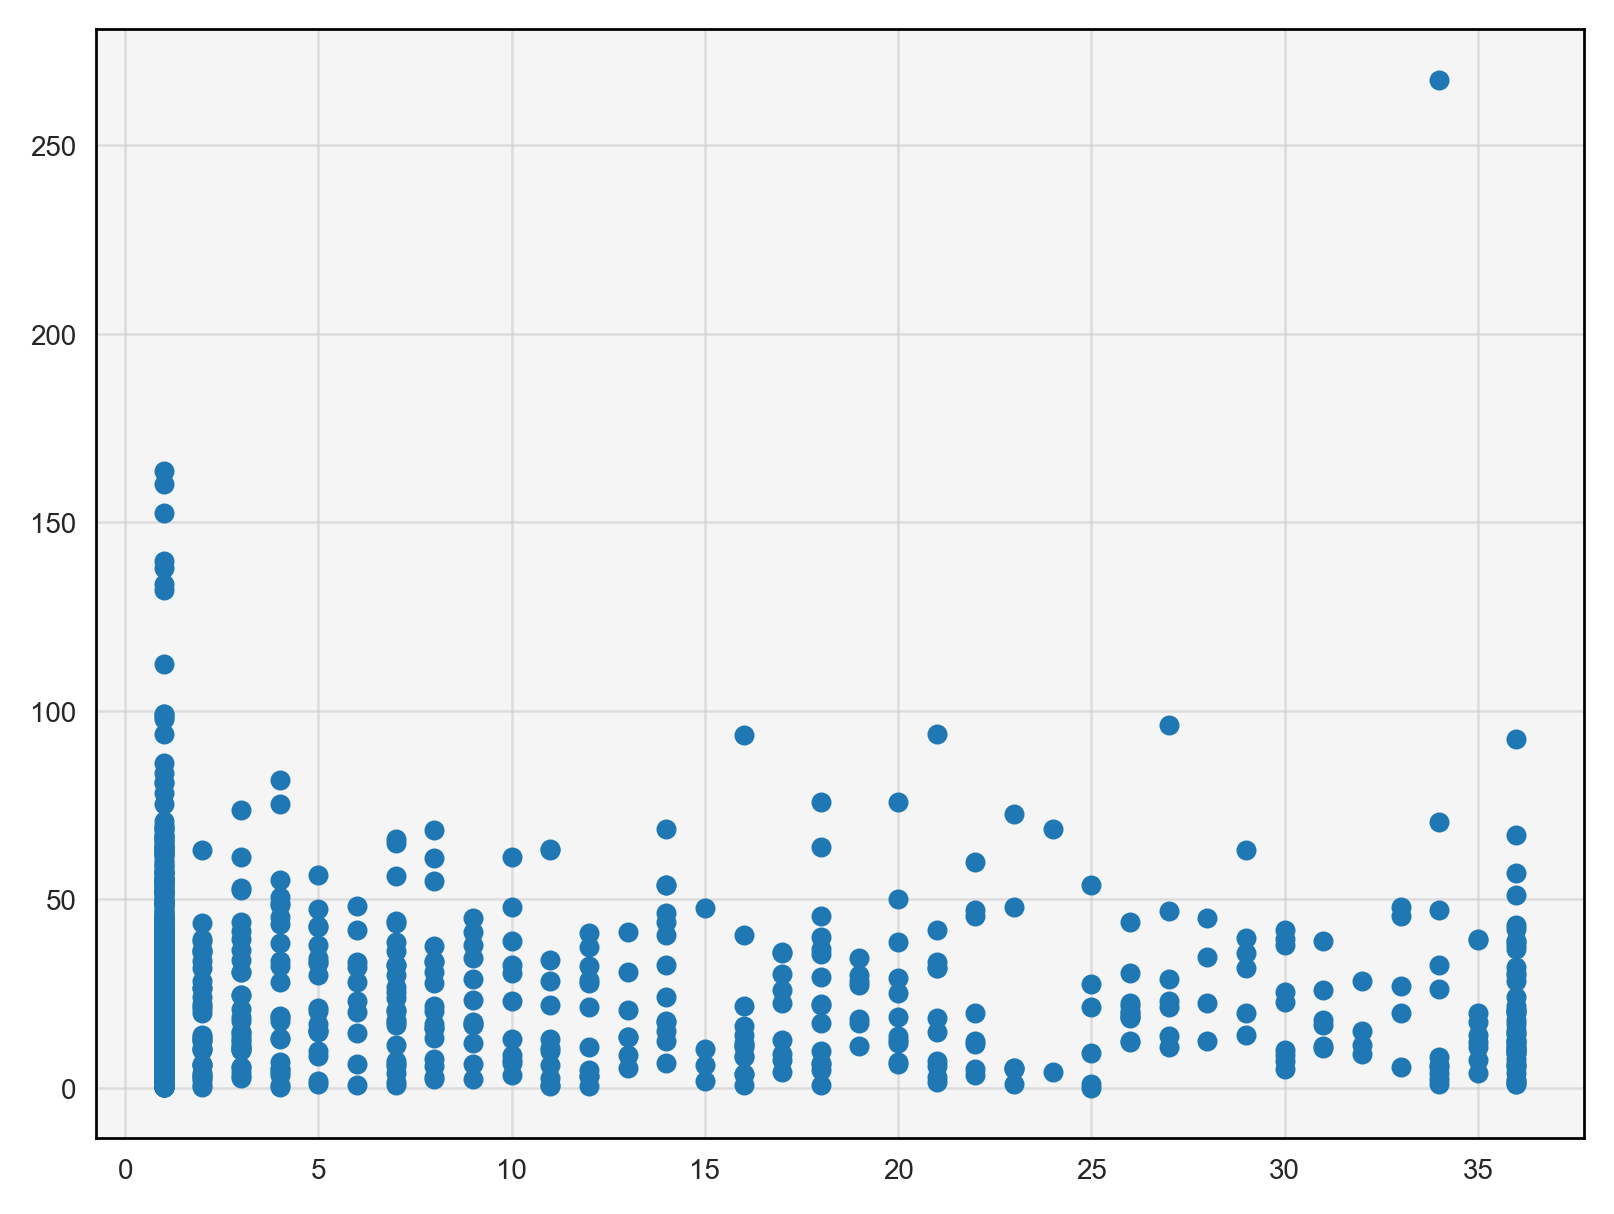

In [39]:
plt.scatter(N_cloud_pixels, metrics["mape"])

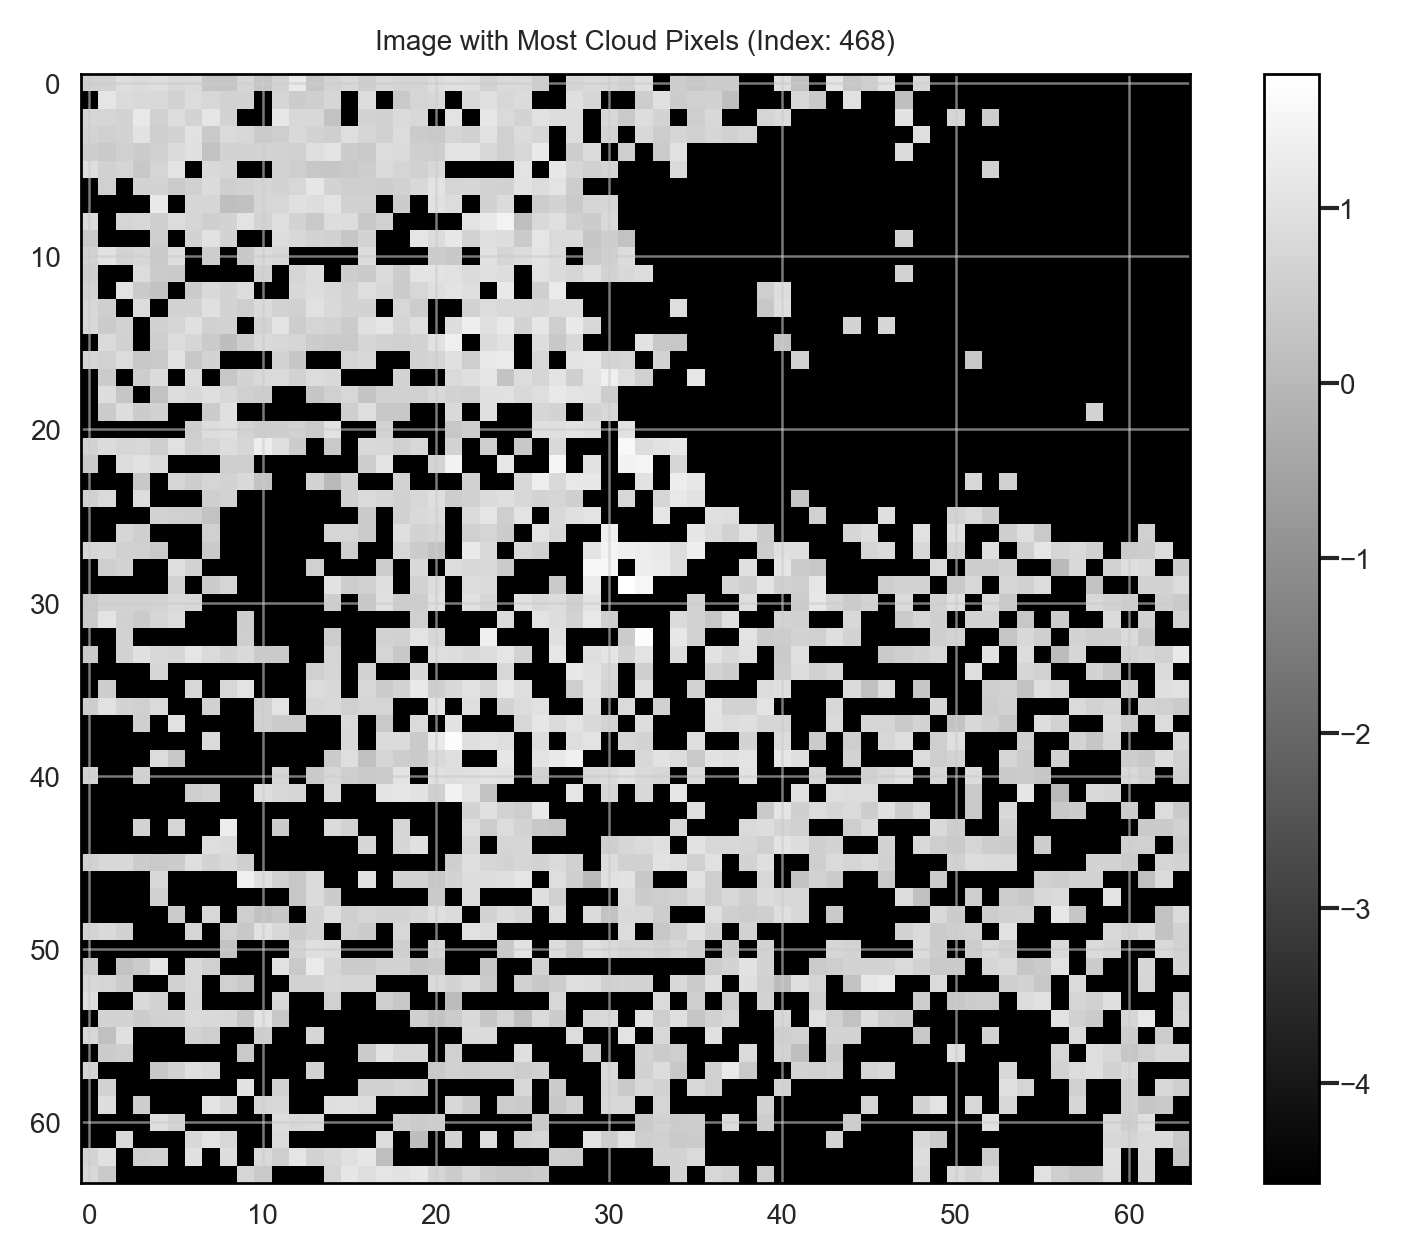

In [47]:
N_cloud_pixels = count_clouds_pixels_in_centered_square(data.x.eval[:, :, :, 0], 64)

# Find the index of the image with the most cloud pixels
index_max_clouds = np.argmax(N_cloud_pixels)

# Plot the image with the most cloud pixels
plt.imshow(data.x.eval[index_max_clouds, :, :, 0], cmap="gray")
plt.title(f"Image with Most Cloud Pixels (Index: {index_max_clouds})")
plt.colorbar()
plt.show()

### Integrated gradients

In [34]:
def get_integ_grad(data: Data_eval, idx: int = None):
    if not idx:
        idx = np.random.choice(data.ds.attrs["N_img"])
    x = tf.cast(data.x.eval[idx : idx + 1], tf.float32)
    baseline_tensor = tf.zeros_like(x)
    integ_grad = model_eval.integrated_gradients(model, x, baseline_tensor).numpy()
    return idx, integ_grad

In [35]:
(idx0, integ_grad_0) = get_integ_grad(data)
(idx1, integ_grad_1) = get_integ_grad(data)
(idx2, integ_grad_2) = get_integ_grad(data)
(idx3, integ_grad_3) = get_integ_grad(data)

In [36]:
plume = np.array(data.x.ds_eval.plume)

In [37]:
list_idx = [idx0, idx1, idx2, idx3]
list_data = [data, data, data, data]
list_plume = [plume, plume, plume, plume]
list_integ_grad = [
    integ_grad_0,
    integ_grad_1,
    integ_grad_2,
    integ_grad_3,
]
list_sources = ["Lippendorf", "Lippendorf", "Lippendorf", "Lippendorf"]

<Figure size 1920x1440 with 0 Axes>

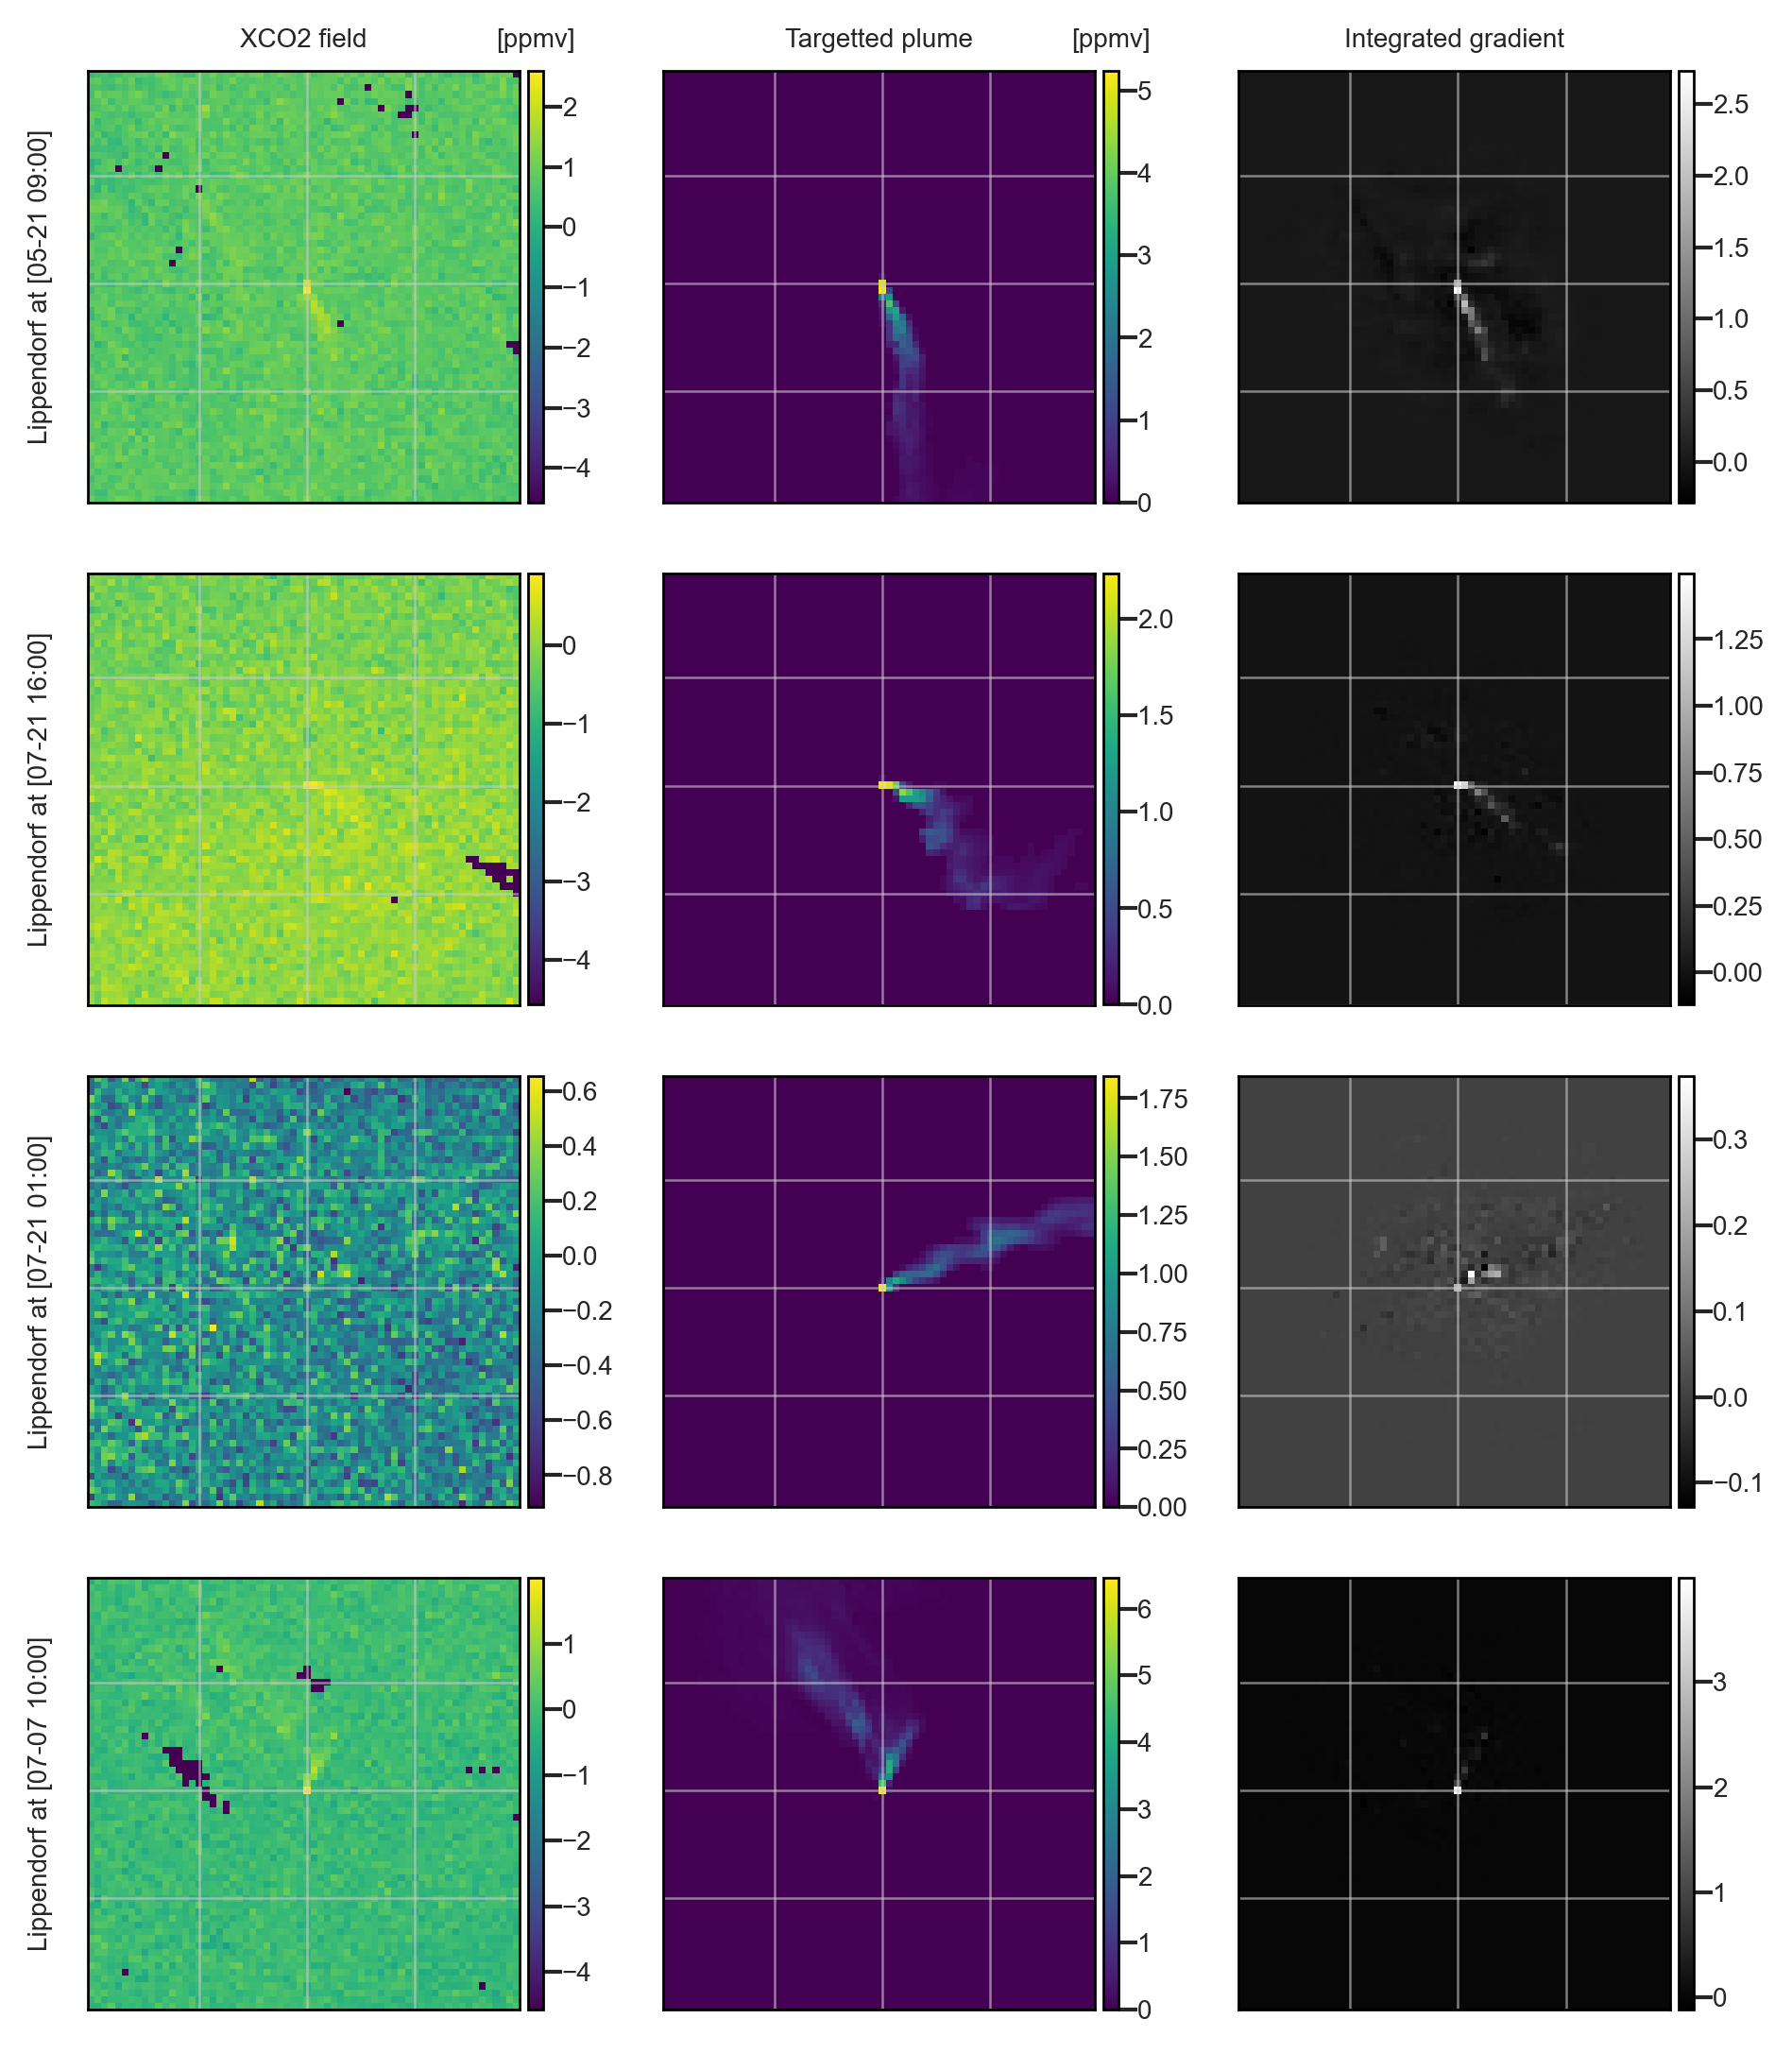

In [38]:
N_idx = 4
N_cols = 3
mympf.setMatplotlibParam(target="pres")
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i_row, (idx, data, plume, integ_grad) in enumerate(
    zip(list_idx, list_data, list_plume, list_integ_grad)
):
    for i_col, image in enumerate(
        [
            np.squeeze(data.x.eval[idx, :, :, 0]),
            np.squeeze(plume[idx, :, :]),
            np.squeeze(integ_grad[:, :, 0]),
        ]
    ):

        i_ax = i_col + i_row * N_cols
        ims[i_ax] = axs[i_ax].imshow(
            image, cmap="gray" if i_col == 2 else None, origin="lower"
        )
        caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))

        cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

list_pd_t = []
for (idx, data) in zip(list_idx, list_data):
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, (pd_t_idx, source) in enumerate(zip(list_pd_t, list_sources)):
    axs[i * N_cols].set_ylabel(
        f"{source} at [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )

axs[0].set_title("XCO2 field")
axs[1].set_title("Targetted plume")
axs[2].set_title("Integrated gradient")

cbars[0].ax.set_title("[ppmv]")
cbars[1].ax.set_title("[ppmv]")

plt.show()